<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_aprendizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Aprendizado

# Importações

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# from sklearn.utils import resample

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

SEMENTE  = 2001088 + 2001247 + 2003061 + 2008193 + 2008620 + 2008880

PALETA = 'summer_r'

## Hiperparâmetros TensorFlow

In [3]:
LOTE_TAMANHO = 1024

CAMADAS = 4

CAMADA_UNIDADES      = 50
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'sigmoid'

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['accuracy']

ITERACOES = 50

## Funções

In [4]:
def avaliar_previsoes(alvos, previsoes):

    print(classification_report(alvos, previsoes))

    ConfusionMatrixDisplay.from_predictions(alvos, previsoes, values_format='d', cmap=PALETA)
    plt.grid(False)

    relatorio = classification_report(alvos, previsoes, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def obter_conjuntos(dados_treino, dados_validacao, q_modelos=10):

    conjuntos = []

    for m in range(q_modelos):

        print(f'Modelo {m} de {q_modelos}.')

        modelo = Sequential()

        [modelo.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
        modelo.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

        modelo.compile(loss=PERDA,
                       optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                       metrics=METRICAS)

        modelo.fit(dados_treino,
                   epochs=ITERACOES,
                   validation_data=dados_validacao,
                   verbose=0)
        
        conjuntos.append(modelo)

    return conjuntos

def obter_previsoes(conjuntos, dados_validacao):
    
    previsoes = []

    for modelo in conjuntos:
        previsoes.append(modelo.predict(dados_validacao, verbose=0))
    
    return tf.constant(tf.squeeze(previsoes))

# Dados

In [5]:
df_sintomas = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_sintomas.zip')

# Aprendizado

## Classificação sobre sintomas e fatores de risco, com EVOLUCAO como atributo alvo

In [6]:
avaliacoes = [None] * 10

### Separação dos dados de treino e teste

In [7]:
X = df_sintomas.drop('EVOLUCAO', axis=1)
y = df_sintomas['EVOLUCAO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

In [8]:
# # Rabalancear dados de treino aumentando a amostragem da classe menor.

# treino = pd.concat([X_train, y_train], axis=1)

# obito = treino[treino['EVOLUCAO'] == 0]
# cura  = treino[treino['EVOLUCAO'] == 1]

# obito = resample(obito, replace=True, n_samples=len(cura), random_state=SEMENTE)

# treino = pd.concat([obito, cura])

# y_train = treino['EVOLUCAO']
# X_train = treino.drop('EVOLUCAO', axis=1)

### Modelo 0: SKLearn Decision Tree

In [9]:
%%time

dtc = DecisionTreeClassifier(criterion='gini', splitter='random', max_features=None, random_state=SEMENTE)

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

# param_grid = {'param': np.linspace(99, 99, 99, dtype='int'),
#               'param': ['value', 'value']}

# grid = GridSearchCV(estimator=dtc,
#                     param_grid=param_grid,
#                     scoring='accuracy',
#                     cv=10,
#                     verbose=3)

# grid.fit(X_train, y_train)

# print(grid.best_params_)

# y_pred = grid.predict(X_test)

CPU times: user 2.36 s, sys: 46.5 ms, total: 2.41 s
Wall time: 3.91 s


              precision    recall  f1-score   support

           0       0.44      0.21      0.28     16796
           1       0.70      0.87      0.78     36185

    accuracy                           0.66     52981
   macro avg       0.57      0.54      0.53     52981
weighted avg       0.62      0.66      0.62     52981



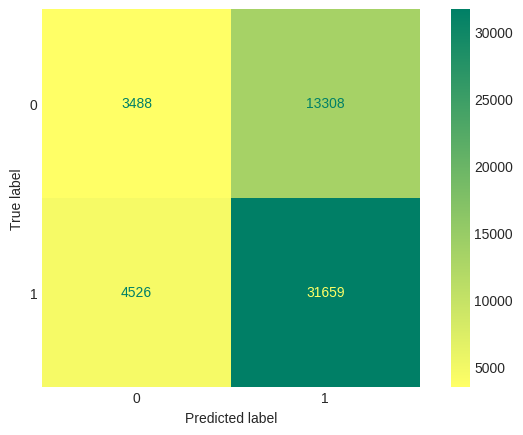

In [10]:
avaliacoes[0] = avaliar_previsoes(y_test, y_pred)

### Modelo 1: SKLearn Random Forest

In [11]:
%%time

rfc = RandomForestClassifier(n_estimators=50, criterion='gini', bootstrap=True, oob_score=True, warm_start=True, random_state=SEMENTE)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

CPU times: user 29.5 s, sys: 619 ms, total: 30.1 s
Wall time: 34 s


              precision    recall  f1-score   support

           0       0.47      0.18      0.26     16796
           1       0.70      0.91      0.79     36185

    accuracy                           0.67     52981
   macro avg       0.58      0.54      0.52     52981
weighted avg       0.63      0.67      0.62     52981



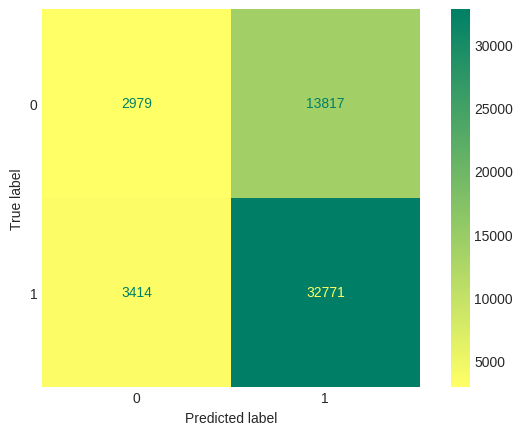

In [12]:
avaliacoes[1] = avaliar_previsoes(y_test, y_pred)

### Modelo 2: SKLearn AdaBoost

In [13]:
%%time

abc = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=SEMENTE)

abc.fit(X_train, y_train)

y_pred = abc.predict(X_test)

CPU times: user 12 s, sys: 981 ms, total: 13 s
Wall time: 13 s


              precision    recall  f1-score   support

           0       0.54      0.10      0.16     16796
           1       0.70      0.96      0.81     36185

    accuracy                           0.69     52981
   macro avg       0.62      0.53      0.49     52981
weighted avg       0.65      0.69      0.60     52981



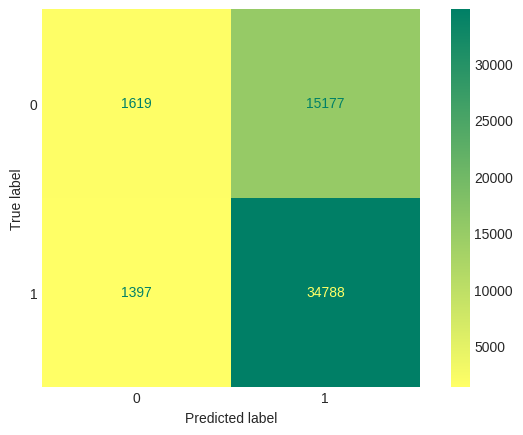

In [14]:
avaliacoes[2] = avaliar_previsoes(y_test, y_pred)

### Modelo 3: SKLearn Gradient Boosting

In [15]:
%%time

gbc = GradientBoostingClassifier(loss='log_loss', n_estimators=50, learning_rate=1.0, criterion='friedman_mse', warm_start=True, max_depth=3, random_state=SEMENTE)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

CPU times: user 20.1 s, sys: 36.2 ms, total: 20.1 s
Wall time: 20.1 s


              precision    recall  f1-score   support

           0       0.56      0.12      0.19     16796
           1       0.70      0.96      0.81     36185

    accuracy                           0.69     52981
   macro avg       0.63      0.54      0.50     52981
weighted avg       0.65      0.69      0.61     52981



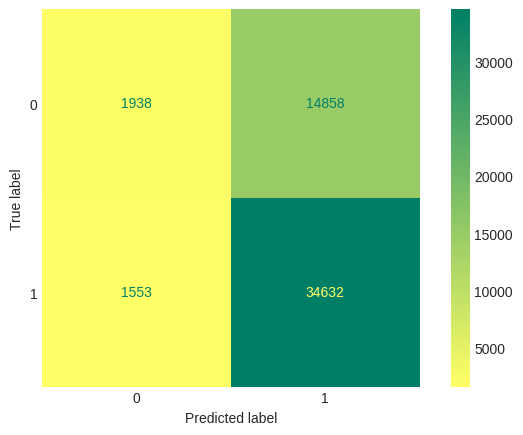

In [16]:
avaliacoes[3] = avaliar_previsoes(y_test, y_pred)

### Datasets

In [17]:
dataset_X_train = Dataset.from_tensor_slices(X_train)
dataset_X_test  = Dataset.from_tensor_slices(X_test)
dataset_y_train = Dataset.from_tensor_slices(y_train)
dataset_y_test  = Dataset.from_tensor_slices(y_test)

dataset_train = Dataset.zip((dataset_X_train, dataset_y_train))
dataset_test  = Dataset.zip((dataset_X_test, dataset_y_test))

dataset_train = dataset_train.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dataset_test  = dataset_test.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

### Modelo 4: TensorFlow Dense

In [18]:
%%time

tf.random.set_seed(SEMENTE)

tfd = Sequential()

[tfd.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
tfd.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfd.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfd.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfd.predict(dataset_test, verbose=0))

CPU times: user 3min 19s, sys: 7.22 s, total: 3min 26s
Wall time: 2min 25s


              precision    recall  f1-score   support

           0       0.52      0.13      0.21     16796
           1       0.70      0.94      0.80     36185

    accuracy                           0.69     52981
   macro avg       0.61      0.54      0.51     52981
weighted avg       0.64      0.69      0.62     52981



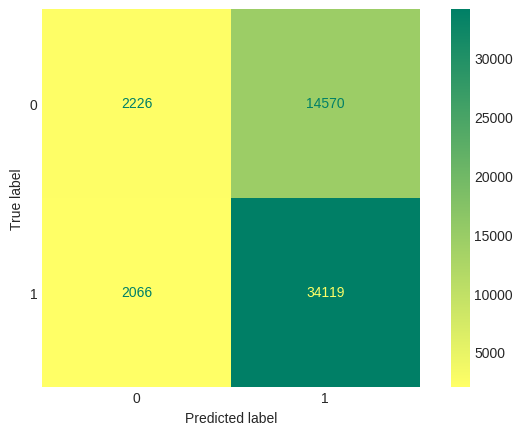

In [19]:
avaliacoes[4] = avaliar_previsoes(y_test, y_pred)

### Modelo 5: TensorFlow Ensemble

In [20]:
%%time

conjuntos = obter_conjuntos(dados_treino=dataset_train, dados_validacao=dataset_test, q_modelos=5)

CPU times: user 16min 43s, sys: 36.3 s, total: 17min 19s
Wall time: 11min 14s


In [21]:
previsoes = obter_previsoes(conjuntos=conjuntos, dados_validacao=dataset_test)

y_pred = tf.round(tf.reduce_mean(previsoes, axis=0))

              precision    recall  f1-score   support

           0       0.55      0.12      0.19     16796
           1       0.70      0.96      0.81     36185

    accuracy                           0.69     52981
   macro avg       0.63      0.54      0.50     52981
weighted avg       0.65      0.69      0.61     52981



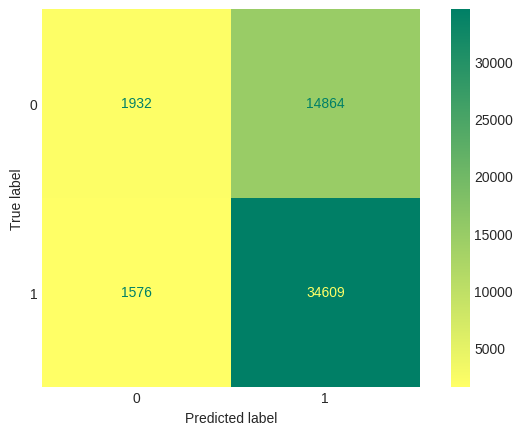

In [22]:
avaliacoes[5] = avaliar_previsoes(y_test, y_pred)

### Comparação de modelos

In [23]:
comparacao = pd.DataFrame([a for a in avaliacoes if a is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

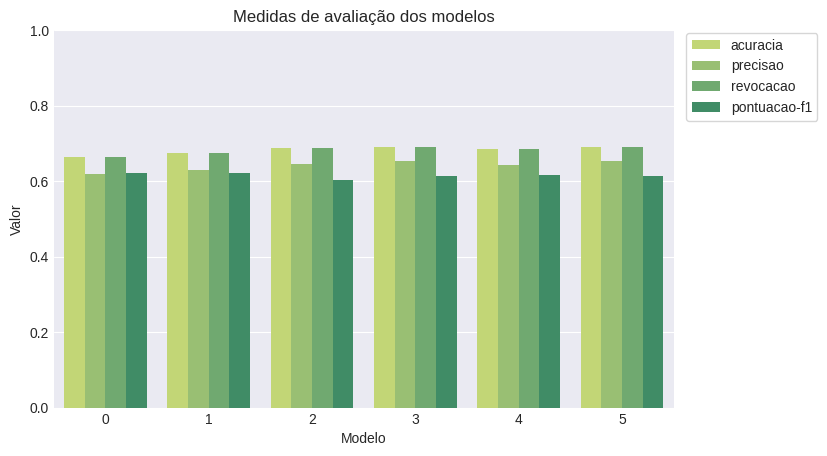

In [24]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette=PALETA)

plt.ylim(0, 1)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')

plt.legend(loc=(1.02, 0.76), frameon=True, facecolor='white');